In [1]:
# Yannick Oreal
# 2025-11-27
# AI2 bootcamp - module 2 - project
# Extract/Transform/Visualize data from API https://api.artic.edu

import requests
import csv
import random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import io
import os
import numpy as np
from IPython.display import display

default_path = os.path.abspath(os.getcwd())

##################################################################################################
# fonction pour récupérer les informations d'une oeuvre
# paramètre
# art_id = numéro id d'une peinture
# retourne un fichier json
def get_artic_edu_artwork_json(art_id):
    # appel api
    url =  "https://api.artic.edu/api/v1/artworks/" + str(art_id) + "?fields=id,title,image_id,artist_title,artist_display,artist_id,dimensions_detail,medium_display,place_of_origin,main_reference_number"
    response = requests.get(url)
    
    # check erreur
    if response.status_code == 200:
        return response.json()['data']
    else:
        #print(f"erreur API : {response.status_code}")
        return None

#################################################################################################
# fonction pour afficher les informations d'une oeuvre
# paramètres
# dic = fichier json (data) renvoyé par l'api d'artic.edu.api
# img_save = sauve l'image jpg
# affiche les informations et retourne uniquement l'url de l'image (et si pas d'url la chaine 'no image')
def display_artwork_informations(dic):
    # affiche les attributs de l'oeuvre
    for key in dic:
        if key=='dimensions_detail':
            for dim in dic[key][0]:
                dicbis = dic[key][0]
                print(f"dimension {dim}={dicbis[dim]}")
        else:
            print(f"{key}={dic[key]}")
    
#################################################################################################
# fonction pour récupérer uniquement l'image d'une oeuvre
# paramètres
# image_id = identifiant de l'image à télécharger (entier)
# display_mode = on affiche l'image après le téléchargement (booleen)
# export_mode = on sauvegarde l'image sous forme de jpeg en plus de la retourner en bits (booleen)
def get_artwork_image(image_id,display_mode,export_mode,n):

    # recupere l'image de l'oeuvre
    artwork_url = "https://www.artic.edu/iiif/2/" + str(image_id) + "/full/843,/0/default.jpg"
    response = requests.get(artwork_url)
    # si l'image est récupérable
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        
        # si display_mode alors affiche l'image 
        if display_mode:
            display(img)

        # si export_mode alors sauve l'image sous forme de jpg
        if export_mode:
            # création dossier artworks_img si il n'existe pas
            img_path = os.path.abspath(os.getcwd()) + "\\random_artworks_" + str(n) + "_img\\"
            if not os.path.exists(img_path):
                os.makedirs(img_path)
            img.save(img_path + image_id + ".jpg")
            print("export image:",image_id)
 
        # retourne l'image
        return image_to_byte_array(img)

    else:
        # si pas d'image
        return None


#################################################################################################
# fonction pour convertir l'image en bits
# paramètre
# image = objet image (PIL)
def image_to_byte_array(image):
  # BytesIO is a file-like buffer stored in memory
  imgByteArr = io.BytesIO()
  # image.save expects a file-like as a argument
  image.save(imgByteArr, format=image.format)
  # Turn the BytesIO object back into a bytes object
  imgByteArr = imgByteArr.getvalue()
  return imgByteArr

    
################################################################################################
# fonction pour récupérer n oeuvres aléatoirement
# paramètres
# n = le nombre d'oeuvres (entier de 1 a 100000)
# csv_save = doit on sauvegarder ou non un fichier csv avec les id/titres/url images (booleen)
# display_mode = on affiche l'image après le téléchargement (booleen)
# export_mode = on sauvegarde l'image sous forme de jpeg en plus de la retourner en bits (booleen)
# verbose_mode = affiche les infos (booleen)
def get_n_random_artwork(n,csv_save,display_mode,export_mode,verbose_mode):
    # initialisation listes
    if csv_save:
        id_list = []
        title_list = []
        img_url_list = []
        artist_title_list = []
        artist_display_list = []
        artist_id_list = []
        medium_display_list = []
        place_of_origin_list = []
        img_list = []
        ref_number_list = []

    # boucle pour récuperer n oeuvres
    for i in range(1,n+1):
        # boucle pour générer aléatoirement un id et vérifie si on peut récupérer les infos, sinon recommence
        id_valide = False
        while id_valide == False:
            # genere un entier aléatoire entre 1 et 100000 
            artwork_id = random.randint(1,1000000)
            
            # appel de l'api artic.edu api pour récupérer le json d'une oeuvre
            artwork_information_dic = get_artic_edu_artwork_json(artwork_id)
            
            # si le json est pas null alors on sort de la boucle
            if artwork_information_dic!=None:
                id_valide = True
        
        # affiche les infos de l'oeuvre
        print(f"information oeuvre {i} récupérée")
        if verbose_mode:
            display_artwork_informations(artwork_information_dic)

        # récupère l'image
        return_img = get_artwork_image(artwork_information_dic['image_id'],display_mode,export_mode,n)
        
        # sauvegarde les infos de l'oeuvre (si paramètre csv_save est Vrai)
        if csv_save:
            id_list.append(str(artwork_information_dic['id']))
            title_list.append(artwork_information_dic['title'])
            artist_title_list.append(artwork_information_dic['artist_title'])
            artist_display_list.append(artwork_information_dic['artist_display'].replace('\n',''))
            medium_display_list.append(artwork_information_dic['medium_display'])
            place_of_origin_list.append(artwork_information_dic['place_of_origin'])
            if return_img is None:
                img_url_list.append("no image")
            else:
                img_url_list.append("https://www.artic.edu/iiif/2/" + str(artwork_information_dic['image_id']) + "/full/843,/0/default.jpg")
            img_list.append(return_img)
            ref_number_list.append(artwork_information_dic['main_reference_number'])
            artist_id_list.append(artwork_information_dic['artist_id'])

    # genere le dataframe et le sauve au même niveau que le notebook  (si paramètre csv_save est Vrai)
    if csv_save:                                  
        df_artworks = pd.DataFrame([id_list, title_list, artist_title_list,artist_display_list,medium_display_list,place_of_origin_list,img_url_list,img_list,ref_number_list])
        df_artworks = df_artworks.transpose()
        df_artworks.columns = ['id', 'title', 'artist_title','artist_display','medium_display','place_of_origin','img_url','img','ref_number']
        df_artworks.to_csv('random_artworks_' +str(n) + '.csv', index=False)



In [225]:
################################################################################################
# appel de la fonction principale
# get_n_random_artwork(n,csv_save,display_mode,export_mode,verbose_mode)
get_n_random_artwork(1500,True,False,False,False)

information oeuvre 1 récupérée
information oeuvre 2 récupérée
information oeuvre 3 récupérée
information oeuvre 4 récupérée
information oeuvre 5 récupérée
information oeuvre 6 récupérée
information oeuvre 7 récupérée
information oeuvre 8 récupérée
information oeuvre 9 récupérée
information oeuvre 10 récupérée
information oeuvre 11 récupérée
information oeuvre 12 récupérée
information oeuvre 13 récupérée
information oeuvre 14 récupérée
information oeuvre 15 récupérée
information oeuvre 16 récupérée
information oeuvre 17 récupérée
information oeuvre 18 récupérée
information oeuvre 19 récupérée
information oeuvre 20 récupérée
information oeuvre 21 récupérée
information oeuvre 22 récupérée
information oeuvre 23 récupérée
information oeuvre 24 récupérée
information oeuvre 25 récupérée
information oeuvre 26 récupérée
information oeuvre 27 récupérée
information oeuvre 28 récupérée
information oeuvre 29 récupérée
information oeuvre 30 récupérée
information oeuvre 31 récupérée
information oeuvr

In [6]:
################################################################################################
# fonction pour nettoyer les données du csv
# paramètres
# df = dataframe
def clean_data(df):
    df = df[(~df['title'].isin(['Untitled']))&(~df['img_url'].isin(['no image']))]
    df = df.dropna()
    return df

################################################################################################
# fonction pour transformer les données du csv
# paramètres
# df = dataframe
def transform_data(df):

    # Extraction informations attribut 'medium_display'
    df['medium_display'] = df['medium_display'].str.lower()
    df['medium_display'] = df['medium_display'].str.replace(","," ")
    df['type']=''
    df['type']=np.where(df['medium_display'].str.contains("lithograph"),"lithograph",df['type'])
    df['type']=np.where(df['medium_display'].str.contains("gelatin"),"gelatin",df['type'])
    df['type']=np.where(df['medium_display'].str.contains("oil"),"oil",df['type'])
    df['type']=np.where(df['medium_display'].str.contains("gouache"),"gouache",df['type'])
    df['type']=np.where(df['medium_display'].str.contains("etching"),"etching",df['type'])
    df['type']=np.where(df['medium_display'].str.contains("engraving"),"engraving",df['type'])
    df['type']=np.where(df['medium_display'].str.contains("printing"),"printing",df['type'])
    df['type']=np.where(df['medium_display'].str.contains("graphite"),"graphite",df['type'])
    df['type']=np.where(df['medium_display'].str.contains("woodcut"),"woodcut",df['type'])
    df['type']=np.where(df['medium_display'].str.contains("bronze"),"bronze",df['type'])
    df['type']=np.where(df['type']=='',"other",df['type'])

    # Extraction informations attribut 'ref_number'
    df['year']=df['ref_number'].str[:4]
    df = df[df['year'].str.isnumeric()]        
    df['year']=df['year'].astype('int')

    # Extraction attribut 'place_of_origin'
    df['country']=np.where(df['place_of_origin'].str.contains("United States"),"USA","Other")
    
    # Suppression attributs inutiles pour étape visualisation
    df = df.drop(['ref_number','img','place_of_origin'],axis=1) 
    return df
    
df = pd.read_csv('random_artworks_1000.csv',encoding='latin-1')
df = transform_data(df)
df = clean_data(df)


C:\Users\Raging\AppData\Local\Temp\ipykernel_5224\1444000362.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year']=df['year'].astype('int')
C:\Users\Raging\AppData\Local\Temp\ipykernel_5224\1444000362.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['country']=np.where(df['place_of_origin'].str.contains("United States"),"USA","Other")


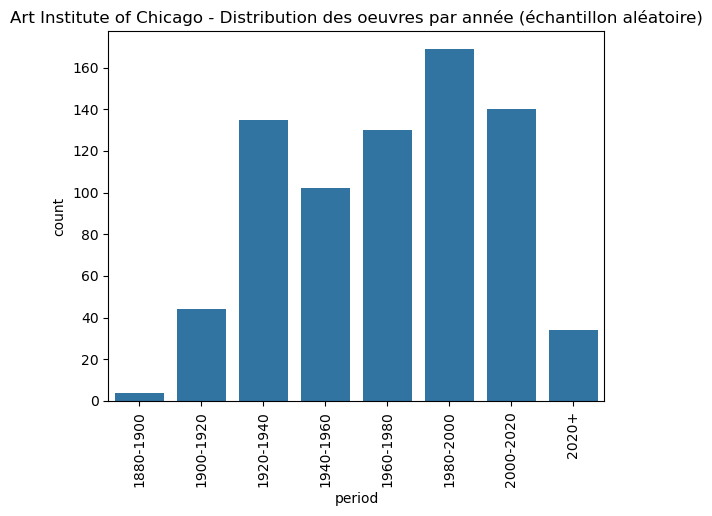

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation
# Nombre d'oeuvres par repartition par année (sur échantillon aléatoire)
labels = ["1880-1900","1900-1920","1920-1940","1940-1960","1960-1980","1980-2000","2000-2020","2020+"]
bins = [1880, 1900,1920,1940,1960,1980,2000,2020,2040]
df['period'] = pd.cut(df['year'], bins=bins, labels=labels, include_lowest=True)
sns.countplot(data=df,x='period')
plt.title("Art Institute of Chicago - Distribution des oeuvres par année (échantillon aléatoire)")
plt.xticks(rotation=90)
plt.show()



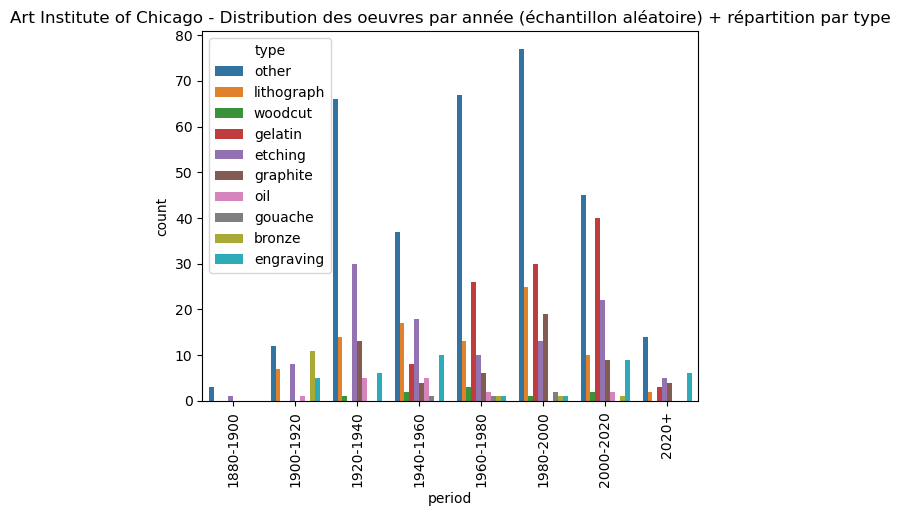

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation
# Nombre d'oeuvres par repartition par année (sur échantillon aléatoire)
labels = ["1880-1900","1900-1920","1920-1940","1940-1960","1960-1980","1980-2000","2000-2020","2020+"]
bins = [1880, 1900,1920,1940,1960,1980,2000,2020,2040]
df['period'] = pd.cut(df['year'], bins=bins, labels=labels, include_lowest=True)
sns.countplot(data=df,x='period',hue='type')
plt.title("Art Institute of Chicago - Distribution des oeuvres par année (échantillon aléatoire) + répartition par type")
plt.xticks(rotation=90)
plt.show()

In [ ]:

# Nombre d'oeuvres par type (sur échantillon aléatoire)
labels = ["1880-1900","1900-1920","1920-1940","1940-1960","1960-1980","1980-2000","2000-2020","2020+"]
bins = [1880, 1900,1920,1940,1960,1980,2000,2020,2040]
df['period'] = pd.cut(df['year'], bins=bins, labels=labels, include_lowest=True)
sns.countplot(data=df,x='period')
plt.title("Art Institute of Chicago - Distribution des oeuvres par année (échantillon aléatoire)")
plt.xlabel("Période")
plt.ylabel("Nb")
plt.xticks(rotation=90)
plt.show()

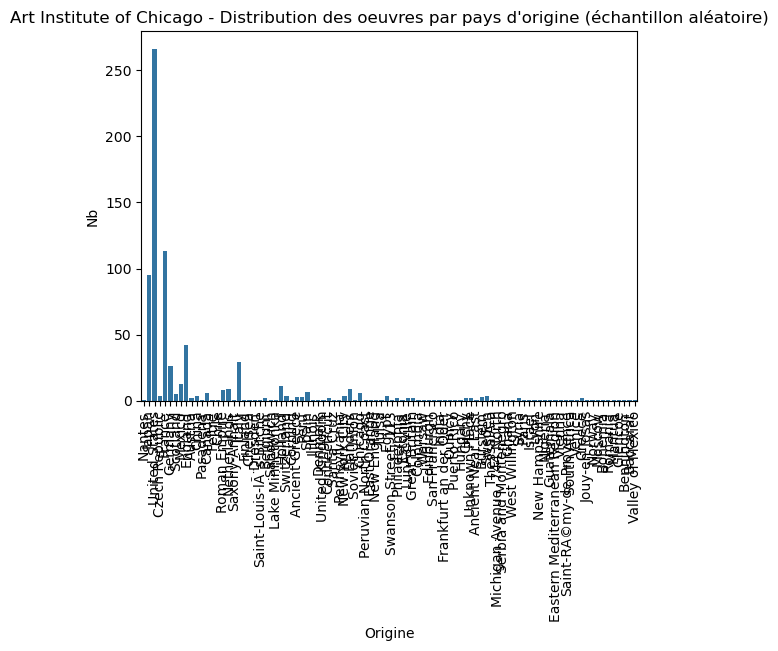

In [5]:
# Nombre d'oeuvres par pays d'origine
sns.countplot(data=df,x='place_of_origin')
plt.title("Art Institute of Chicago - Distribution des oeuvres par pays d'origine (échantillon aléatoire)")
plt.xlabel("Origine")
plt.ylabel("Nb")
plt.xticks(rotation=90)
plt.show()

In [ ]:
import sqlite3

# Tes DataFrames
# Créer une base SQLite en mémoire
conn = sqlite3.connect(':memory:')
pieces.to_sql('pieces', conn, index=False, if_exists='replace')  # créer la table "pieces"

# Créer un curseur
cursor = conn.cursor()

# Exécuter la requête SQL avec RANK()
cursor.execute('''
SELECT machine_id,
       COUNT(*) AS nb_pieces,
       RANK() OVER (ORDER BY COUNT(*) DESC) AS rang
FROM pieces
GROUP BY machine_id
ORDER BY nb_pieces DESC
LIMIT 3;
''')

# Afficher les résultats
resultats = cursor.fetchall()
for row in resultats:
    print(row)

# Fermer la connexion
conn.close()